In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import warnings


In [3]:
train_Mortgage = pd.read_csv('train_Mortgage.csv')
val_Mortgage = pd.read_csv('val_Mortgage.csv')
train_Pension = pd.read_csv('train_Pension.csv')
val_Pension = pd.read_csv('val_Pension.csv')
train_Savings = pd.read_csv('train_Savings.csv')
val_Savings = pd.read_csv('val_Savings.csv')

In [5]:
train_Mortgage.head()

,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,Mortgage
0,43,15,43,0,0,0,0,45,38012,3,13,24,4,0,0,0,6,47,0.000,0
1,44,14,44,0,0,0,0,51,45479,7,6,12,3,1,0,0,8,39,0.000,0
2,25,0,25,1,0,0,0,52,31515,3,-1,0,3,5,0,0,12,34,0.000,0
3,40,5,40,1,0,0,0,69,30782,3,27,36,0,0,0,0,11,18,0.000,0
4,33,4,33,0,0,0,0,46,39377,5,33,36,3,2,4,2,14,38,8.585,0


для начала создадим param_grid для поиска наилучших параметров

In [69]:
models = {
      "Logistic Regression": LogisticRegression(),
      "Ridge Logistic Regression": LogisticRegression(),
      "Lasso Logistic Regression": LogisticRegression(),
      "Elastic Net Logistic Regression": LogisticRegression(),
      "Polynomial Logistic Regression": LogisticRegression()
}
param_grids = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "solver": ["liblinear", "lbfgs"],
        "max_iter": [500, 1000]
    },
    "Ridge Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "penalty": ["l2"],
        "solver": ["liblinear", "lbfgs"],
        "max_iter": [500, 1000]
    },
    "Lasso Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "penalty": ["l1"],
        "solver": ["liblinear"],
        "max_iter": [500, 1000]
    },
    "Elastic Net Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "l1_ratio": [0.2, 0.5, 0.8],
        "penalty": ["elasticnet"],
        "solver": ["saga"],
        "max_iter": [500, 1000]
    }
}

теперь обучим модели четырёх видов логистической регрессии. Их можно будет посмотреть в словаре models_mortgage

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt

def train_and_evaluate_models(train, val, s):

    X_train = train.drop(columns=[s])
    y_train = train[s]
    X_val = val.drop(columns=[s])
    y_val = val[s]

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)


    trained_models = {}
    for model_name, model in models.items():
        print(f"Обучение модели: {model_name}")

        if model_name == "Polynomial Logistic Regression":
            poly = PolynomialFeatures(degree=2)
            X_train_poly = poly.fit_transform(X_train_scaled)
            X_val_poly = poly.transform(X_val_scaled)
            grid_search = GridSearchCV(model, param_grids["Logistic Regression"], cv=5, scoring='roc_auc', n_jobs=-1)
            grid_search.fit(X_train_poly, y_train)
        else:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
            grid_search.fit(X_train_scaled, y_train)

        best_params = grid_search.best_params_
        print(f"Лучшие параметры для {model_name}: {best_params}")

        best_model = grid_search.best_estimator_

        if model_name == "Polynomial Logistic Regression":
            y_val_pred_proba = best_model.predict_proba(X_val_poly)[:, 1]
        else:
            y_val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]

        roc_auc = roc_auc_score(y_val, y_val_pred_proba)
        print(f"ROC-AUC для {model_name}: {roc_auc:.4f}")

        fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

        trained_models[model_name] = {
            'model': best_model,
            'best_params': best_params,
            'roc_auc': roc_auc
        }


    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    return trained_models

Обучение модели: Logistic Regression
Лучшие параметры для Logistic Regression: {'C': 0.001, 'max_iter': 500, 'solver': 'lbfgs'}
ROC-AUC для Logistic Regression: 0.7787
Обучение модели: Ridge Logistic Regression
Лучшие параметры для Ridge Logistic Regression: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
ROC-AUC для Ridge Logistic Regression: 0.7787
Обучение модели: Lasso Logistic Regression
Лучшие параметры для Lasso Logistic Regression: {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
ROC-AUC для Lasso Logistic Regression: 0.7778
Обучение модели: Elastic Net Logistic Regression
Лучшие параметры для Elastic Net Logistic Regression: {'C': 0.01, 'l1_ratio': 0.8, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
ROC-AUC для Elastic Net Logistic Regression: 0.7778
Обучение модели: Polynomial Logistic Regression
Лучшие параметры для Polynomial Logistic Regression: {'C': 0.001, 'max_iter': 500, 'solver': 'lbfgs'}
ROC-AUC для Polynomial Logis

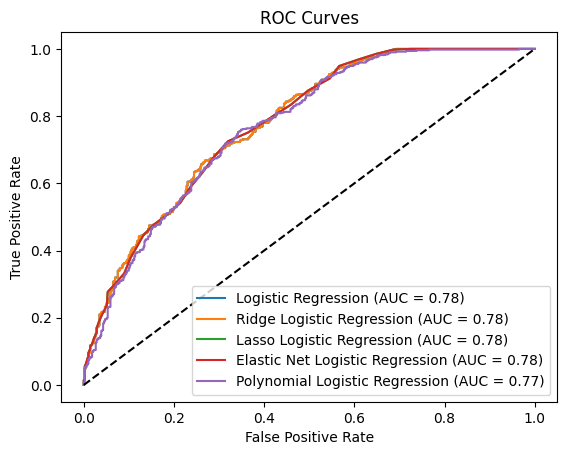

In [8]:
models_Pension = train_and_evaluate_models(train_Pension, val_Pension, "Pension")

Обучение модели: Logistic Regression
Лучшие параметры для Logistic Regression: {'C': 0.1, 'max_iter': 500, 'solver': 'lbfgs'}
ROC-AUC для Logistic Regression: 0.6928
Обучение модели: Ridge Logistic Regression
Лучшие параметры для Ridge Logistic Regression: {'C': 0.1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
ROC-AUC для Ridge Logistic Regression: 0.6928
Обучение модели: Lasso Logistic Regression
Лучшие параметры для Lasso Logistic Regression: {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
ROC-AUC для Lasso Logistic Regression: 0.6928
Обучение модели: Elastic Net Logistic Regression
Лучшие параметры для Elastic Net Logistic Regression: {'C': 1, 'l1_ratio': 0.2, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'}
ROC-AUC для Elastic Net Logistic Regression: 0.6923
Обучение модели: Polynomial Logistic Regression
Лучшие параметры для Polynomial Logistic Regression: {'C': 0.01, 'max_iter': 500, 'solver': 'lbfgs'}
ROC-AUC для Polynomial Logistic Regressi

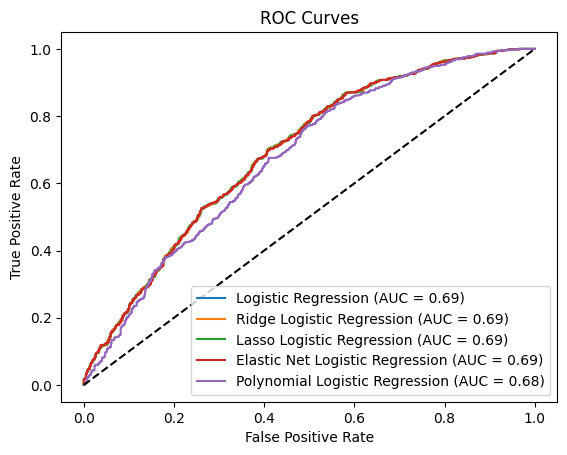

In [9]:
models_Savings = train_and_evaluate_models(train_Savings, val_Savings, "Savings")

Обучение модели: Logistic Regression
Лучшие параметры для Logistic Regression: {'C': 0.01, 'max_iter': 500, 'solver': 'lbfgs'}
ROC-AUC для Logistic Regression: 0.9382
Обучение модели: Ridge Logistic Regression
Лучшие параметры для Ridge Logistic Regression: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
ROC-AUC для Ridge Logistic Regression: 0.9382
Обучение модели: Lasso Logistic Regression
Лучшие параметры для Lasso Logistic Regression: {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
ROC-AUC для Lasso Logistic Regression: 0.9400
Обучение модели: Elastic Net Logistic Regression
Лучшие параметры для Elastic Net Logistic Regression: {'C': 0.01, 'l1_ratio': 0.5, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'}
ROC-AUC для Elastic Net Logistic Regression: 0.9411
Обучение модели: Polynomial Logistic Regression
Лучшие параметры для Polynomial Logistic Regression: {'C': 0.1, 'max_iter': 500, 'solver': 'lbfgs'}
ROC-AUC для Polynomial Logistic R

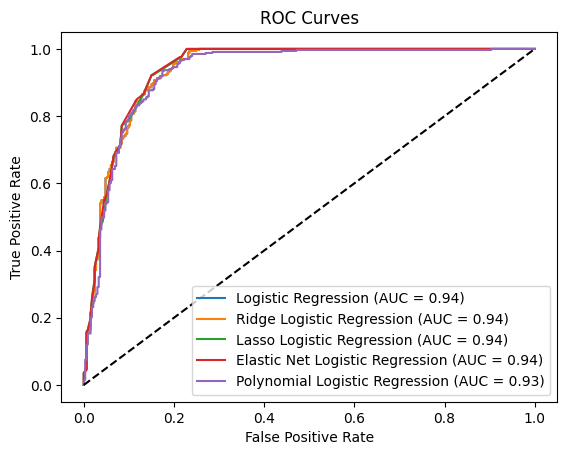

In [10]:
models_Mortgage = train_and_evaluate_models(train_Mortgage, val_Mortgage, "Mortgage")

теперь сохраним модели

In [11]:
import os
from joblib import dump

def save_models(models_dict, folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for model_name, model in models_dict.items():
        file_path = os.path.join(folder_name, f'{model_name}.joblib')
        dump(model, file_path)
        print(f"Модель {model_name} сохранена в {file_path}")

save_models(models_Pension, 'models/models_Pension')
save_models(models_Savings, 'models/models_Savings')
save_models(models_Mortgage, 'models/models_Mortgage')

Модель Logistic Regression сохранена в models/models_Pension/Logistic Regression.joblib
Модель Ridge Logistic Regression сохранена в models/models_Pension/Ridge Logistic Regression.joblib
Модель Lasso Logistic Regression сохранена в models/models_Pension/Lasso Logistic Regression.joblib
Модель Elastic Net Logistic Regression сохранена в models/models_Pension/Elastic Net Logistic Regression.joblib
Модель Polynomial Logistic Regression сохранена в models/models_Pension/Polynomial Logistic Regression.joblib
Модель Logistic Regression сохранена в models/models_Savings/Logistic Regression.joblib
Модель Ridge Logistic Regression сохранена в models/models_Savings/Ridge Logistic Regression.joblib
Модель Lasso Logistic Regression сохранена в models/models_Savings/Lasso Logistic Regression.joblib
Модель Elastic Net Logistic Regression сохранена в models/models_Savings/Elastic Net Logistic Regression.joblib
Модель Polynomial Logistic Regression сохранена в models/models_Savings/Polynomial Logisti

наконец, пропытаемся определить значимость параметров модели, для этого создадим функцию, визуализирующую значимость признаков

In [63]:
import seaborn as sns
feature_names = ['age', 'age_youngest_child', 'debt_equity', 'gender', 'bad_payment',
       'gold_card', 'pension_plan', 'household_debt_to_equity_ratio', 'income',
       'members_in_household', 'months_current_account', 'months_customer',
       'call_center_contacts', 'loan_accounts', 'number_products',
       'number_transactions', 'non_worker_percentage',
       'white_collar_percentage', 'rfm_score']

def analyze(model, name):
    coefficients = model['model'].coef_[0]

    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

    plt.figure(figsize=(5, 3))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance, hue='Feature', palette='viridis', legend=False)
    plt.title('Значимость признаков в модели для ' + name)
    plt.xlabel('Коэффициент')
    plt.ylabel('Признак')
    plt.show()

    # return feature_importance

визуализирем значимость признаков в предсказании логистической регрессиии

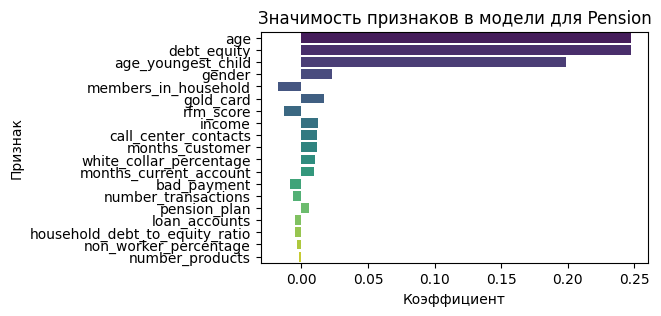

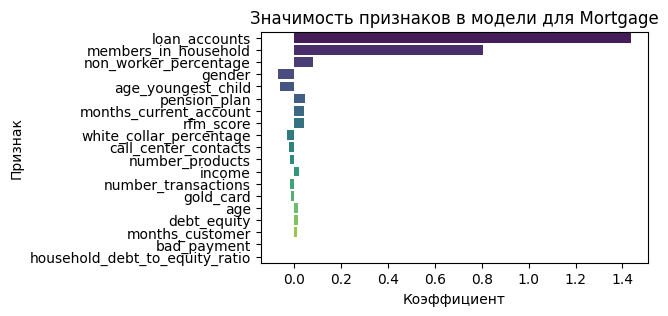

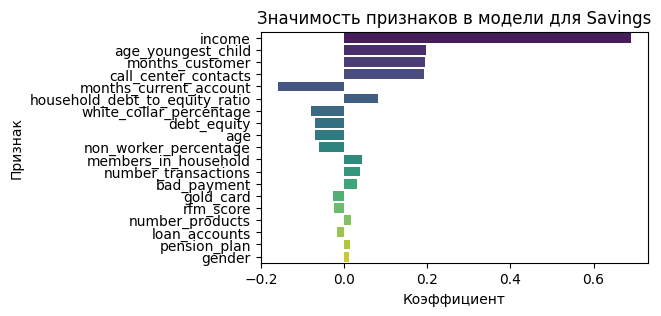

In [64]:
analyze(models_Pension['Logistic Regression'], 'Pension')
analyze(models_Mortgage['Logistic Regression'], 'Mortgage')
analyze(models_Savings['Logistic Regression'], 'Savings')

теперь для RIDGE регрессии

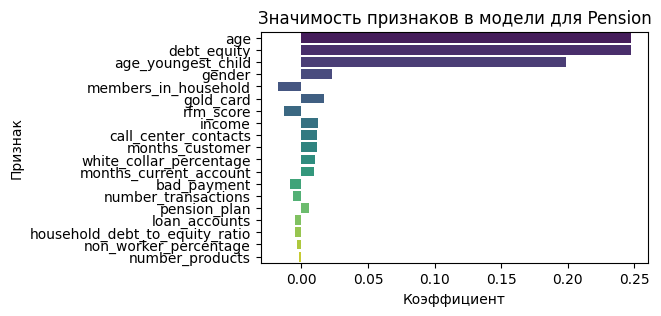

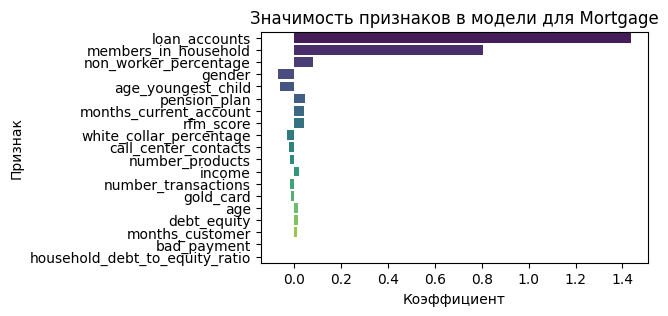

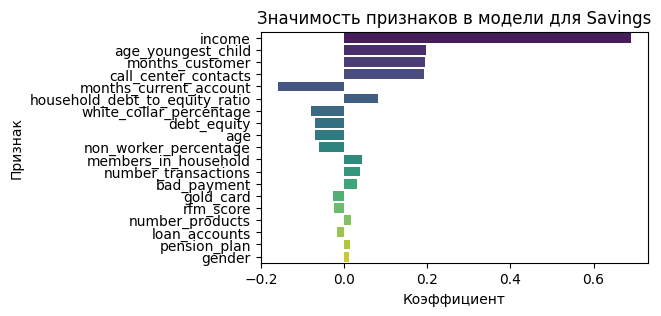

In [65]:
analyze(models_Pension['Ridge Logistic Regression'], 'Pension')
analyze(models_Mortgage['Ridge Logistic Regression'], 'Mortgage')
analyze(models_Savings['Ridge Logistic Regression'], 'Savings')

для Lasso

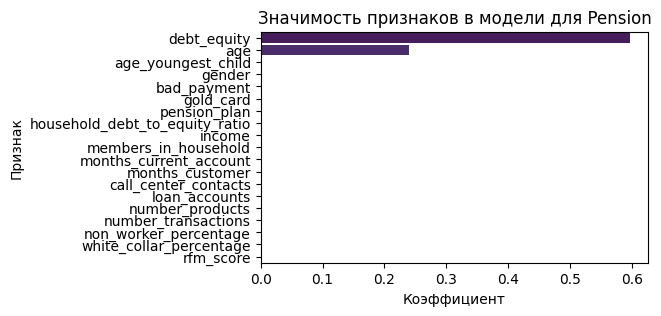

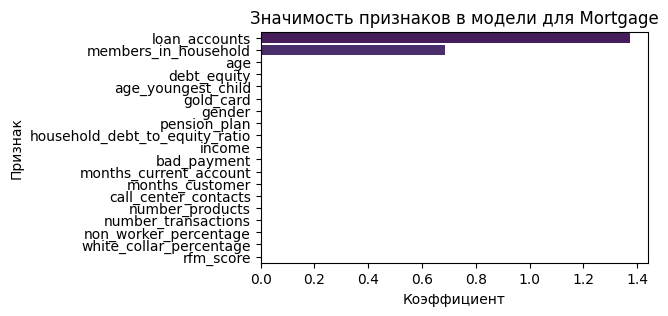

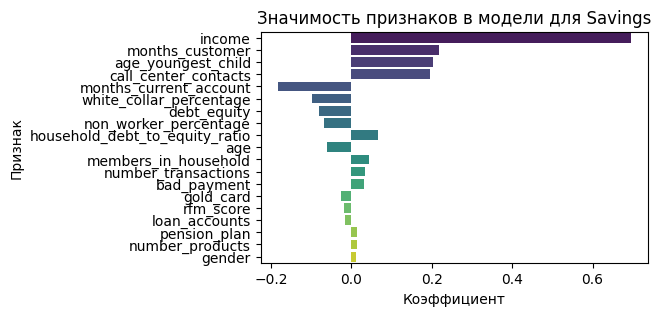

In [66]:
analyze(models_Pension['Lasso Logistic Regression'], 'Pension')
analyze(models_Mortgage['Lasso Logistic Regression'], 'Mortgage')
analyze(models_Savings['Lasso Logistic Regression'], 'Savings')

для elastic net

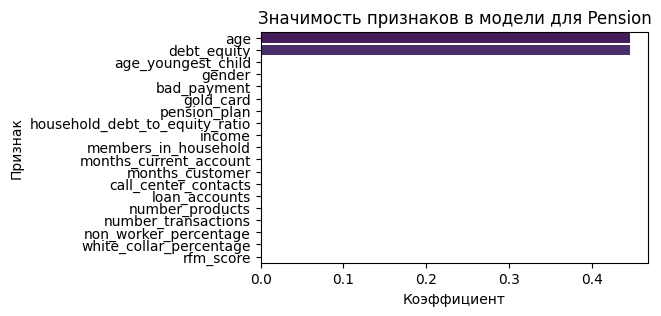

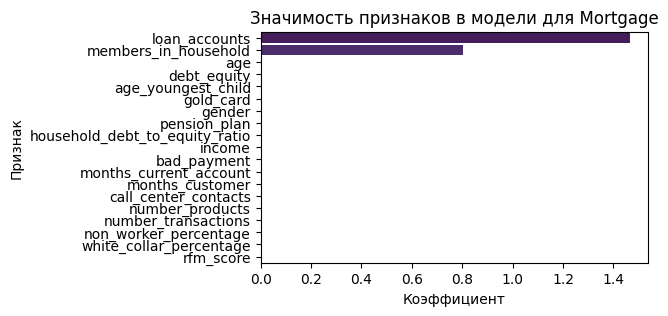

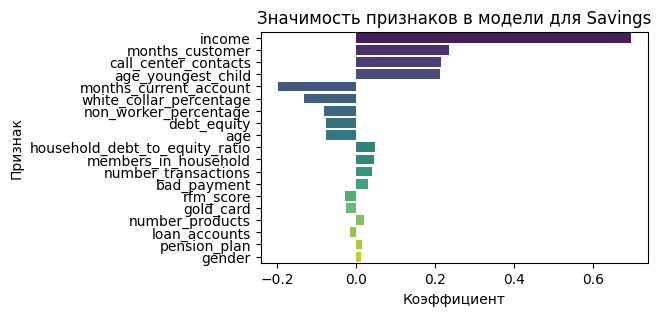

In [68]:
analyze(models_Pension['Elastic Net Logistic Regression'], 'Pension')
analyze(models_Mortgage['Elastic Net Logistic Regression'], 'Mortgage')
analyze(models_Savings['Elastic Net Logistic Regression'], 'Savings')